## Can a vanilla multi-layer perceptron (MLP) learn the XOR gate?

This is an important point I am about to make, as it leads to alot of confusion regarded where and why the bias is introduced:

With shallow models, you inject the bias term into the data matrix, giving you your [design matrix](https://en.wikipedia.org/wiki/Design_matrix). In the first notebook (linearly-separable-spaces.ipynb), we were working with a shallow model and hence introduced the bias column. 

When preparing data for a deep model, the biases are added **after** the input layer, and are present on the target node(s). This is just a convention. You could shift all the biases back, such that there is one present for each input node (building the design matrix), but not present on the output node.

Hence the XOR gate input matrix becomes:

\begin{equation}
X = \begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 0\\
1 & 0 & 1\\
1 & 0 & 0\\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
1 & 1\\
1 & 0\\
0 & 1\\
0 & 0\\
\end{bmatrix}, 
y_{xor} = \begin{bmatrix}
0 \\
1 \\
1 \\
0 \\ \end{bmatrix}
\end{equation}

The target architecture is:
![MLP](media/MLPxorTopology.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

input and target matrices for XOR gate function

In [3]:
X = np.array([
    [1,1],
    [1,0],
    [0,1],
    [0,0]
])
Y = np.array([
    [0],
    [1],
    [1],
    [0],
])

We will now define the MLP.
Notice the weights shape.

_Why is it 3 rows for each?_ 

1 element for the bias, and 2 for the features! Look at the diagram

In [4]:
class MLP:
    
    def __init__(self):
        '''
        Initialise the weights of the network 
        3 layers:
        hidden layer weights: (3,2) shape 
        output weights:       (3,1) shape
        '''
        n_in = 2
        n_out = 1
        Glorot_weight_init_scale =  (2/( n_in + n_out))**(1/2)
        
        self.W1 = np.random.normal(loc=0.0,
                                   scale=Glorot_weight_init_scale,
                                   size=(3,2))
        self.W2 = np.random.normal(loc=0.0,
                                   scale=Glorot_weight_init_scale,
                                   size=(3,1))
        
    def activation(self,z):
        '''
        Rectified linear unit
        '''
        return np.maximum(z,0)
    

    def forward(self,x):
        '''
        In TF, and most frameworks, the first (or zeroth if you know you know) 
        dimension is the batch dimension 
        
        Suppose we had a SINGLE input, x, of shape (2,). This would 
        require use to inject the addtional batch dimension 
        '''
        if len(x.shape) == 1:
            # testing for existence of batch dimension 
            x = x[np.newaxis,...]
            # this adds a new axis to the front of the vector/matrix/tensor
            # if you wanted to add to the end of it, do: 
            #  x = x[...,np.newaxis]
            
        b1 = np.ones(shape=(x.shape[0], 1))
        x1_design = np.hstack((b1,x))
        h1 = x1_design @ self.W1
        x2 = self.activation(h1)
        
        b2 = np.ones(shape=(x2.shape[0], 1))
        x2_design = np.hstack((b2,x2))
        h2 = x2_design @ self.W2
        
        # linear activation
        x3 = h2 
        
        return h1, x2, h2, x3         

Now we have the MLP defined, lets setup the training routine. We need to fix some learning parameters beforehand:

In [5]:
MAX_EPOCHS = 10000
LR = 0.01 

In [6]:

def trainer(model):
    
model = MLP()


    loss_hist, W1_hist, W2_hist = [],[],[]
    for epoch in range(MAX_EPOCHS):
        # forward pass
        h1, x2, h2, x3 = model.forward(X)

        loss = (1/4) * np.sum((x3 -Y)**2)/len(Y)
        loss_hist.append(loss)
        if epoch % 100:
            print(f"Epoch: {epoch}\nMSE: {loss:.4f}")

        # This is backpropagation. Note that many frameworks 
        # have implemented automatic differentiation techniques 
        # so that you dont need to concern yourself with 
        # the derivatives of activations and weight updates. 

        delta_2 = 0.5 * ( x3 - Y)
        g_prime_1 = np.heaviside(x2, 0)
        # Delta_1 has shape (4, 2)
        delta_1 = delta_2 @ model.W2[1:3, :].T * g_prime_1
        # Biases of layers connecting input and hidden layers
        model.W1[0, :] -= LR * np.sum(delta_1[:, :], axis=0)
          # Weights of layers connecting input and hidden layers 
        model.W1[1:3, :] -= LR * X.T @ delta_1
          # Biases of layers connecting hidden and output layers
        model.W2[0, :] -= LR * np.sum(delta_2[:, :], axis=0)
          # Weights of layers connecting hidden and output layers
        model.W2[1:3, :] -= LR * x2.T @ delta_2


        W1_hist.append(np.copy(model.W1))
        W2_hist.append(np.copy(model.W2))
    
    
tot_loss_hist = np.array(loss_hist)
tot_W1_hist = np.array(W1_hist)
tot_W2_hist = np.array(W2_hist)
    

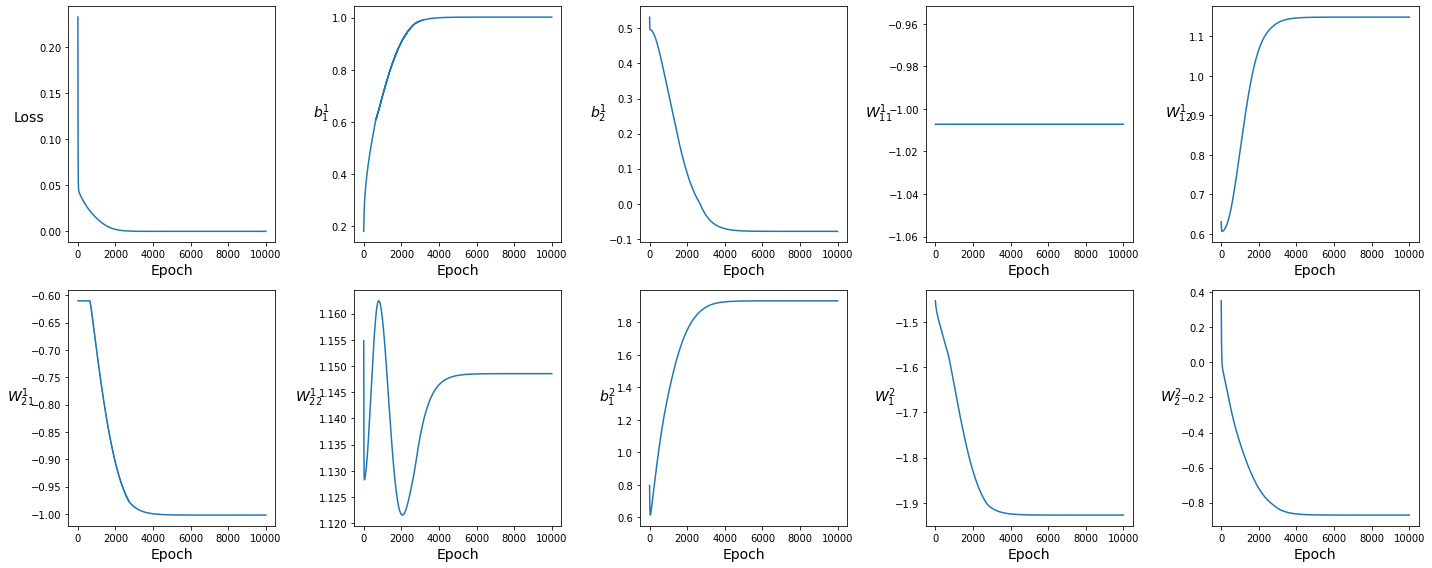

In [18]:
def plot_weight_convergence():

    plt.figure(figsize=(20, 8))
    ax = plt.subplot(2, 5, 1)
    ax.plot(loss_hist[:])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 2)
    ax.plot(tot_W1_hist[:,0,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$b^{1}_1$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 3)
    ax.plot(tot_W1_hist[:,0,1])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$b^{1}_2$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 4)
    ax.plot(tot_W1_hist[:,1,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{1}_{11}$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 5)
    ax.plot(tot_W1_hist[:,1,1])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{1}_{12}$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 6)
    ax.plot(tot_W1_hist[:,2,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{1}_{21}$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 7)
    ax.plot(tot_W1_hist[:,2,1])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{1}_{22}$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 8)
    ax.plot(tot_W2_hist[:,0,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$b^{2}_{1}$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 9)
    ax.plot(tot_W2_hist[:,1,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{2}_1$', fontsize=14, rotation=0, labelpad=10)
    ax = plt.subplot(2, 5, 10)
    ax.plot(tot_W2_hist[:,2,0])
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('$W^{2}_2$', fontsize=14, rotation=0, labelpad=10)
    plt.tight_layout()
    plt.show()
    
plot_weight_convergence()

Now the trained MLP model is able to model the XOR Gate